In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
import string
from scipy import interpolate
from scipy.stats import linregress

from pyproj import CRS,Transformer,Proj
import time

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


In [4]:
def mask_by_label(ds, labels, value):
    mask = xr.DataArray(
        labels == value,
        coords={"time": ds.time},
        dims="time"
    )
    return ds.where(mask, drop=True)

In [5]:
def plot_four(ds_precip, title, cbar_label,dict_WT):
    pplt.rc.update(small=12, large=14)

    f, axs = pplt.subplots(proj='cyl', ncols=2,nrows=2, axwidth=5, axheight=2.5)

    colmap = 'BrBG'
    levels_WT = np.arange(-70,80,10)

    labels_dataset = list(dict_WT.values())
    keys_WT = list(dict_WT.keys())

    mean_precip = ds_precip['pr'].mean(dim='time')

    for lab in range(4):
        m=axs[lab].pcolormesh(lon, lat, 100*(ds_precip[labels_dataset[lab]].mean(dim='time')-mean_precip)/mean_precip, levels=levels_WT,cmap=colmap)
        axs[lab].contour(lon, lat, alps)
        axs[lab].format(title=keys_WT[lab],titlesize='15px')

    f.colorbar(m,label= cbar_label,labelsize='x-large',ticklabelsize='large')

    f.format(**normal_format)
    f.format(ocean=False,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],
             suptitle=title)

In [6]:
def plot_five(ds_precip, title, title1, cbar_label,dict_WT):
    pplt.rc.update(small=12, large=14)

    f, axs = pplt.subplots([[1, 1], [1, 1], [2, 3], [4, 5]], refnum=1, refwidth=7, proj='cyl')#,axwidth=3)

    mean_precip = ds_precip['pr'].mean(dim='time')

    m=axs[0].pcolormesh(lon, lat, mean_precip, levels = np.arange(0,11,1),cmap='Blues')
    axs[0].contour(lon, lat, alps)
    axs[0].format(title=title1,titlesize='15px')
    
    colmap = 'BrBG'
    levels_WT = np.arange(-70,80,10)

    labels_dataset = list(dict_WT.values())
    keys_WT = list(dict_WT.keys())

    for lab in range(4):
        m2=axs[lab+1].pcolormesh(lon, lat, 100*(ds_precip[labels_dataset[lab]].mean(dim='time')-mean_precip)/mean_precip, levels=levels_WT,cmap=colmap)
        axs[lab+1].contour(lon, lat, alps)
        axs[lab+1].format(title=keys_WT[lab],titlesize='15px')

    f.colorbar(m,label= 'mmWe',labelsize='x-large',ticklabelsize='large',loc='r',rows=(1,2),length=0.9)
    f.colorbar(m2,label= cbar_label,labelsize='x-large',ticklabelsize='large',rows=(3,4),length=0.9)

    f.format(**multiplot_format)
    f.format(ocean=False,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],
             suptitle=title)

In [7]:
pplt.rc['figure.facecolor'] = 'white'


## Winter

/tmp/ipykernel_3819899/2647780523.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/2647780523.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

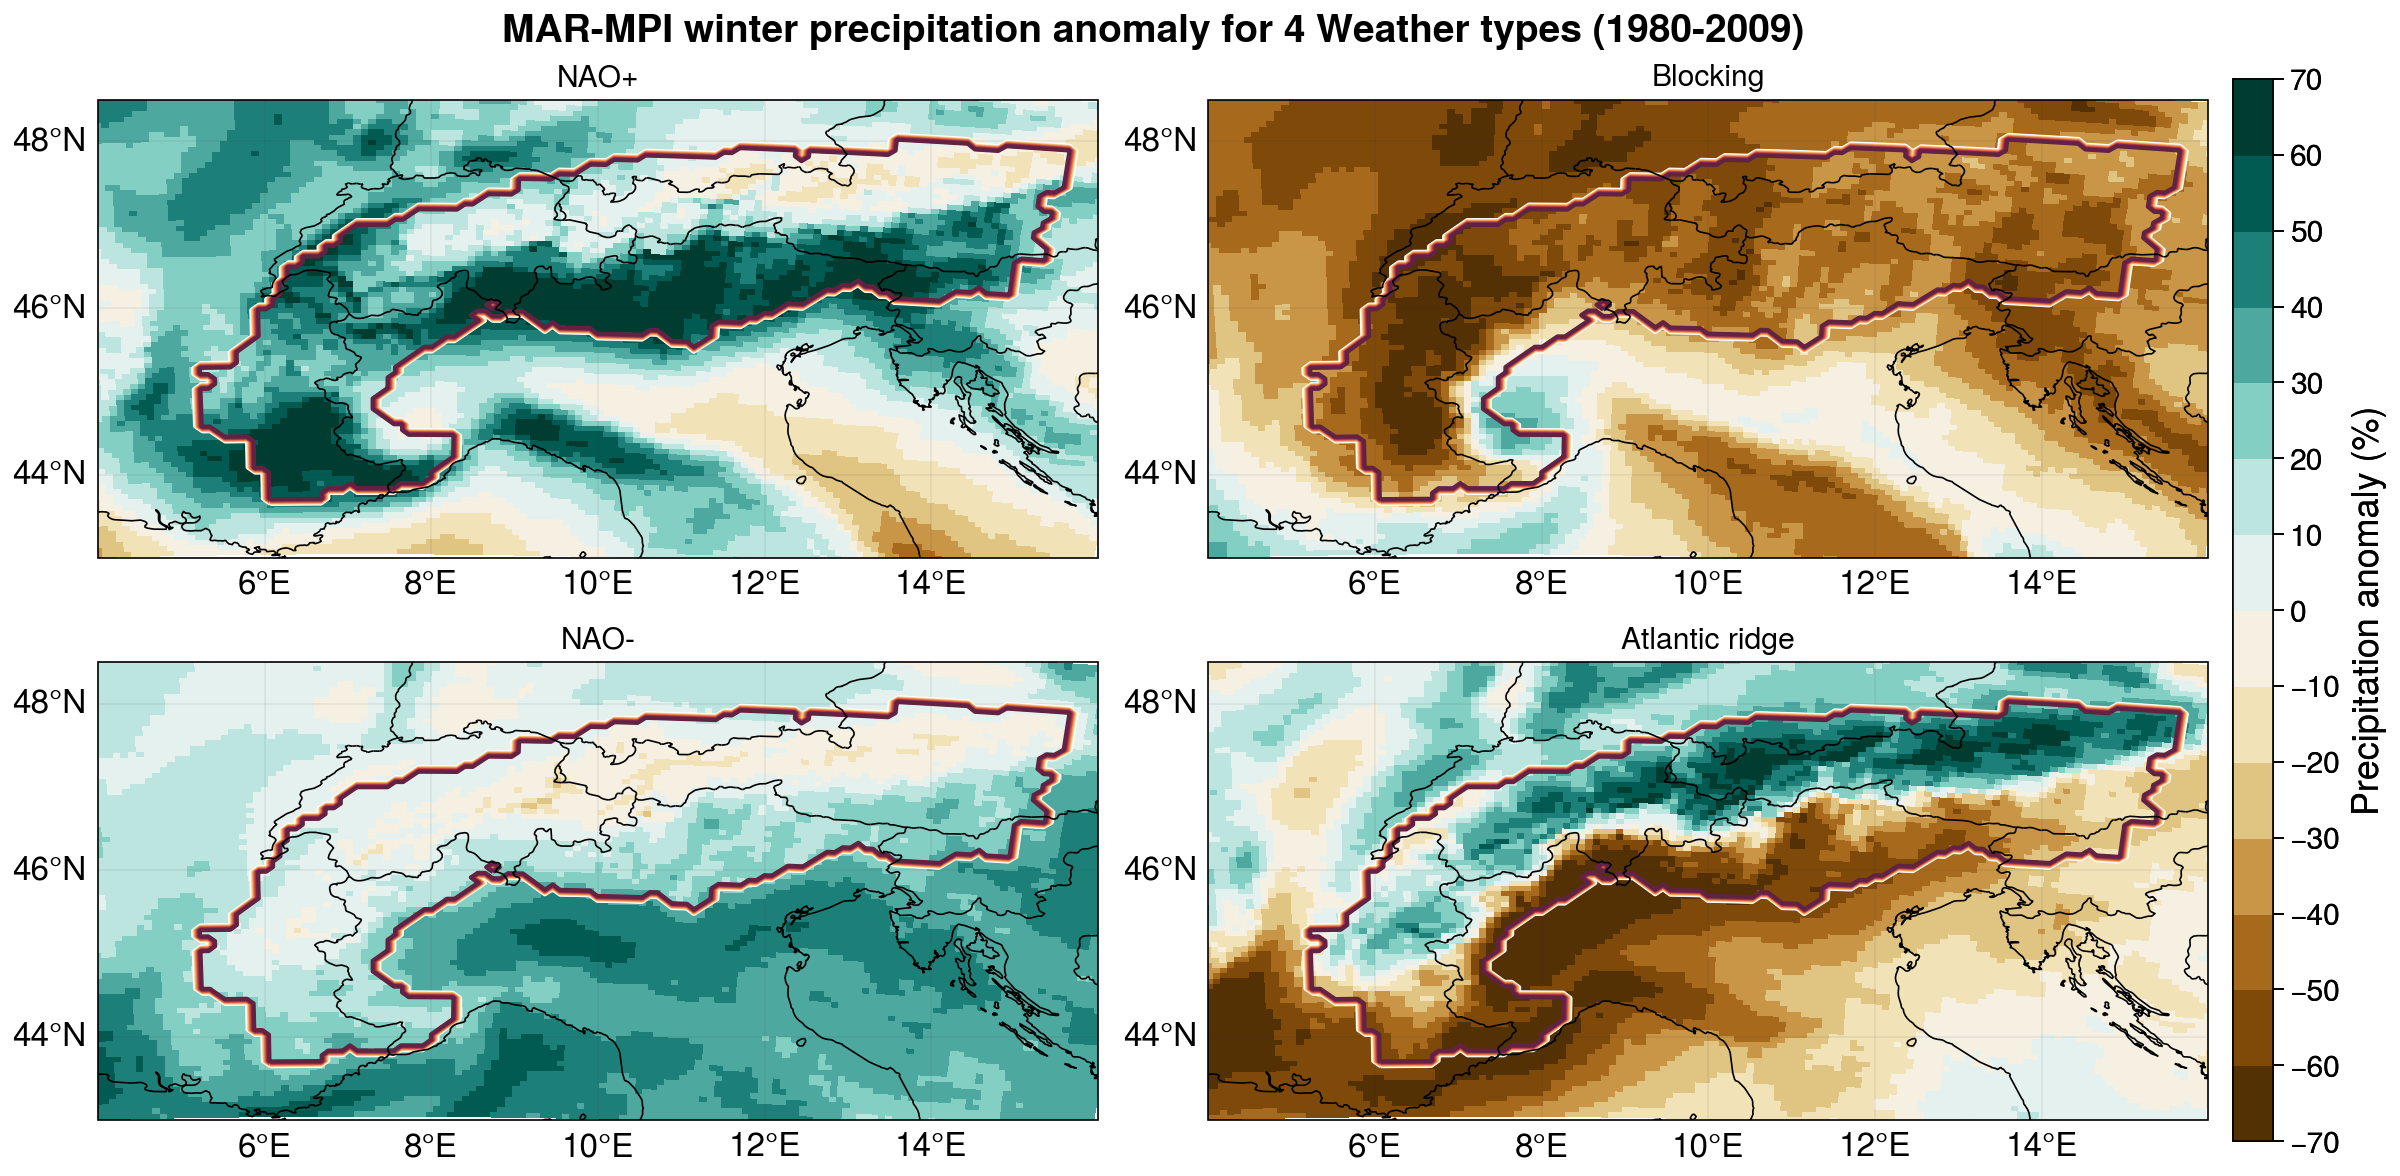

In [8]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1980-2009_winter.nc')

plot_four(ds_precip, 'MAR-MPI winter precipitation anomaly for 4 Weather types (1980-2009)', 'Precipitation anomaly (%)',
         dict_WT={'NAO+': 'pr3', 'Blocking': 'pr1', 'NAO-': 'pr0', 'Atlantic ridge': 'pr2'})

/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

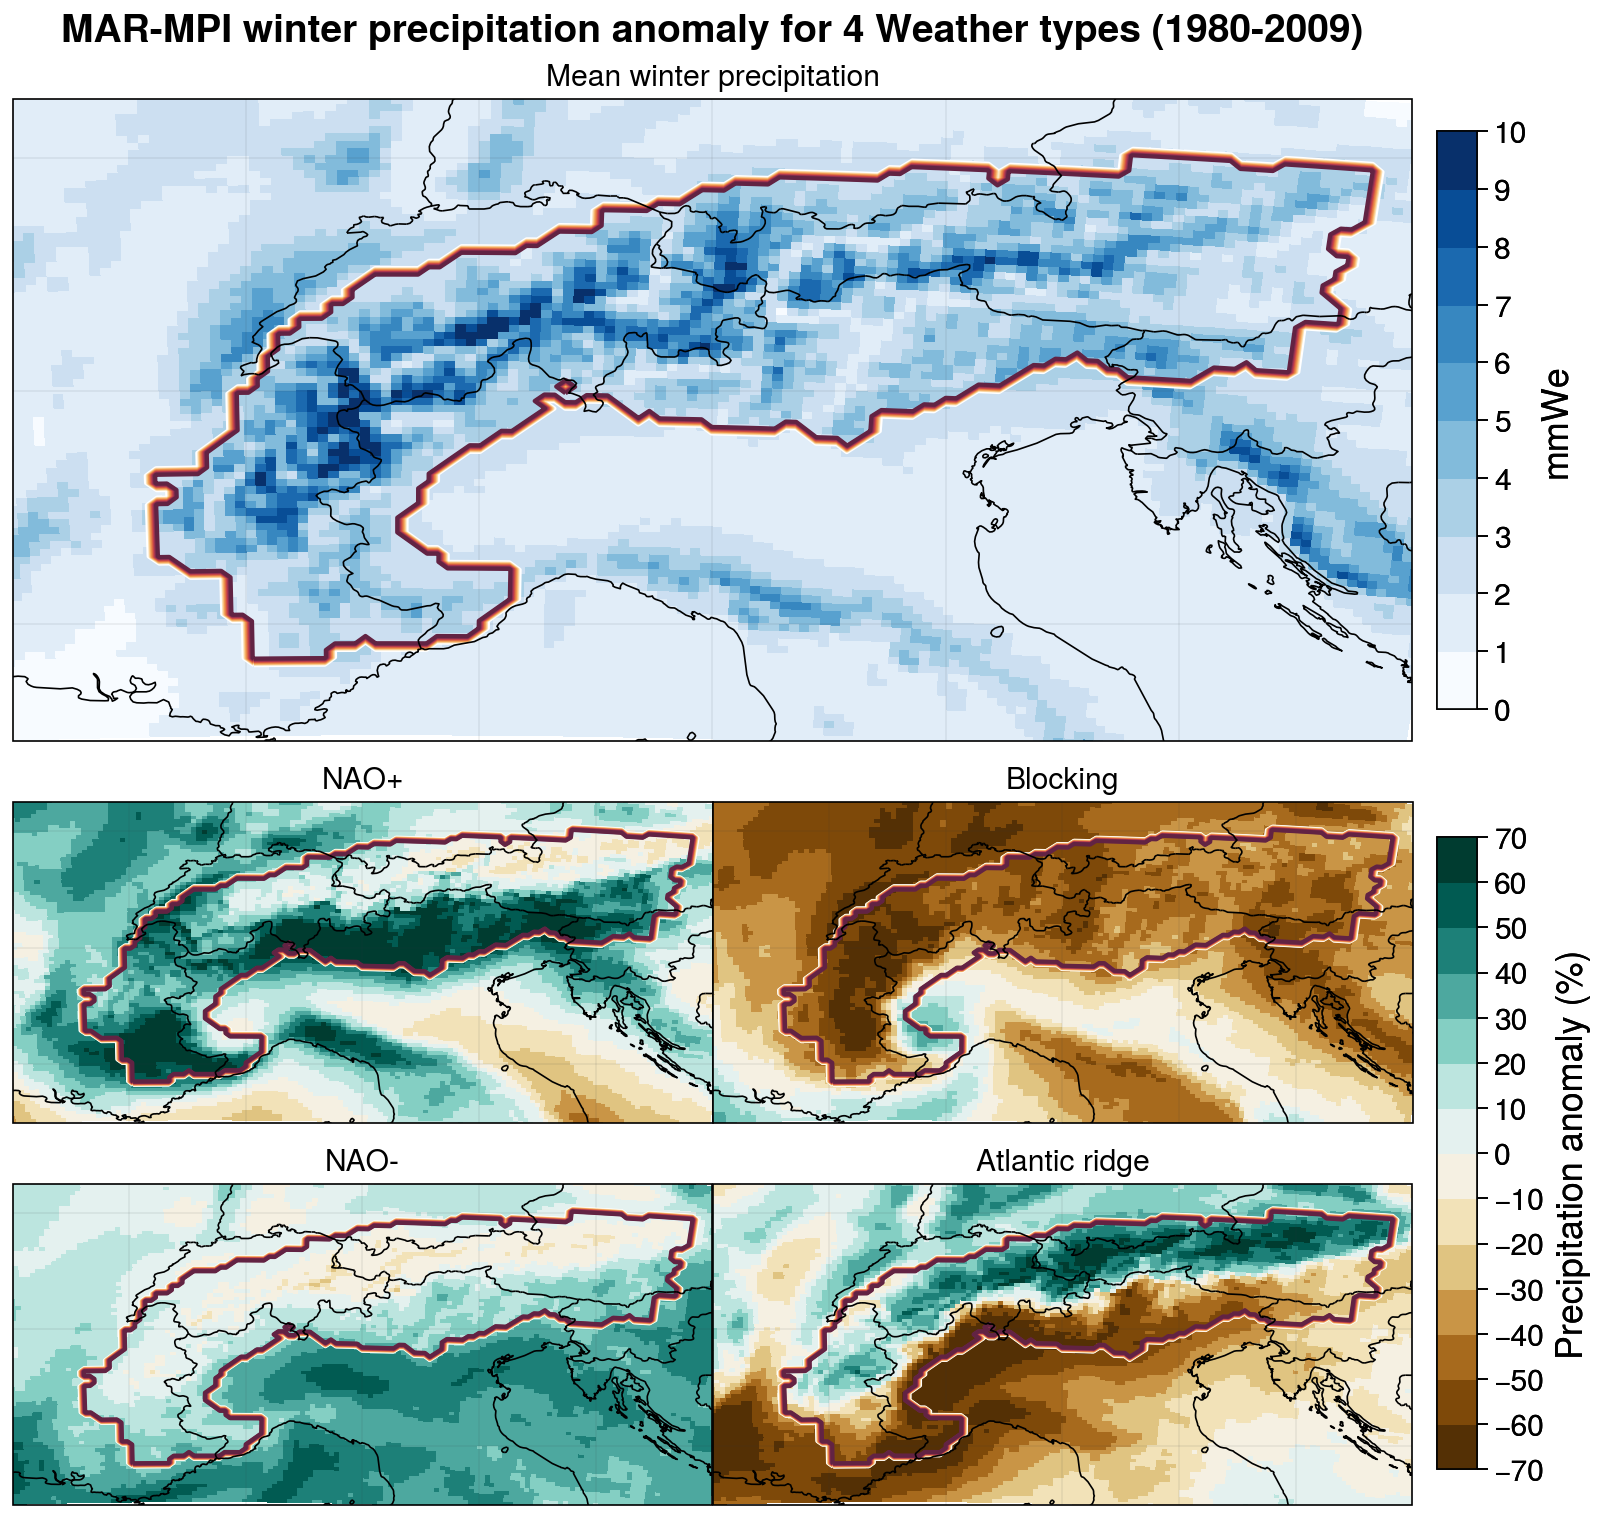

In [9]:
plot_five(ds_precip, 'MAR-MPI winter precipitation anomaly for 4 Weather types (1980-2009)','Mean winter precipitation', 'Precipitation anomaly (%)',
         dict_WT={'NAO+': 'pr3', 'Blocking': 'pr1', 'NAO-': 'pr0', 'Atlantic ridge': 'pr2'})

/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

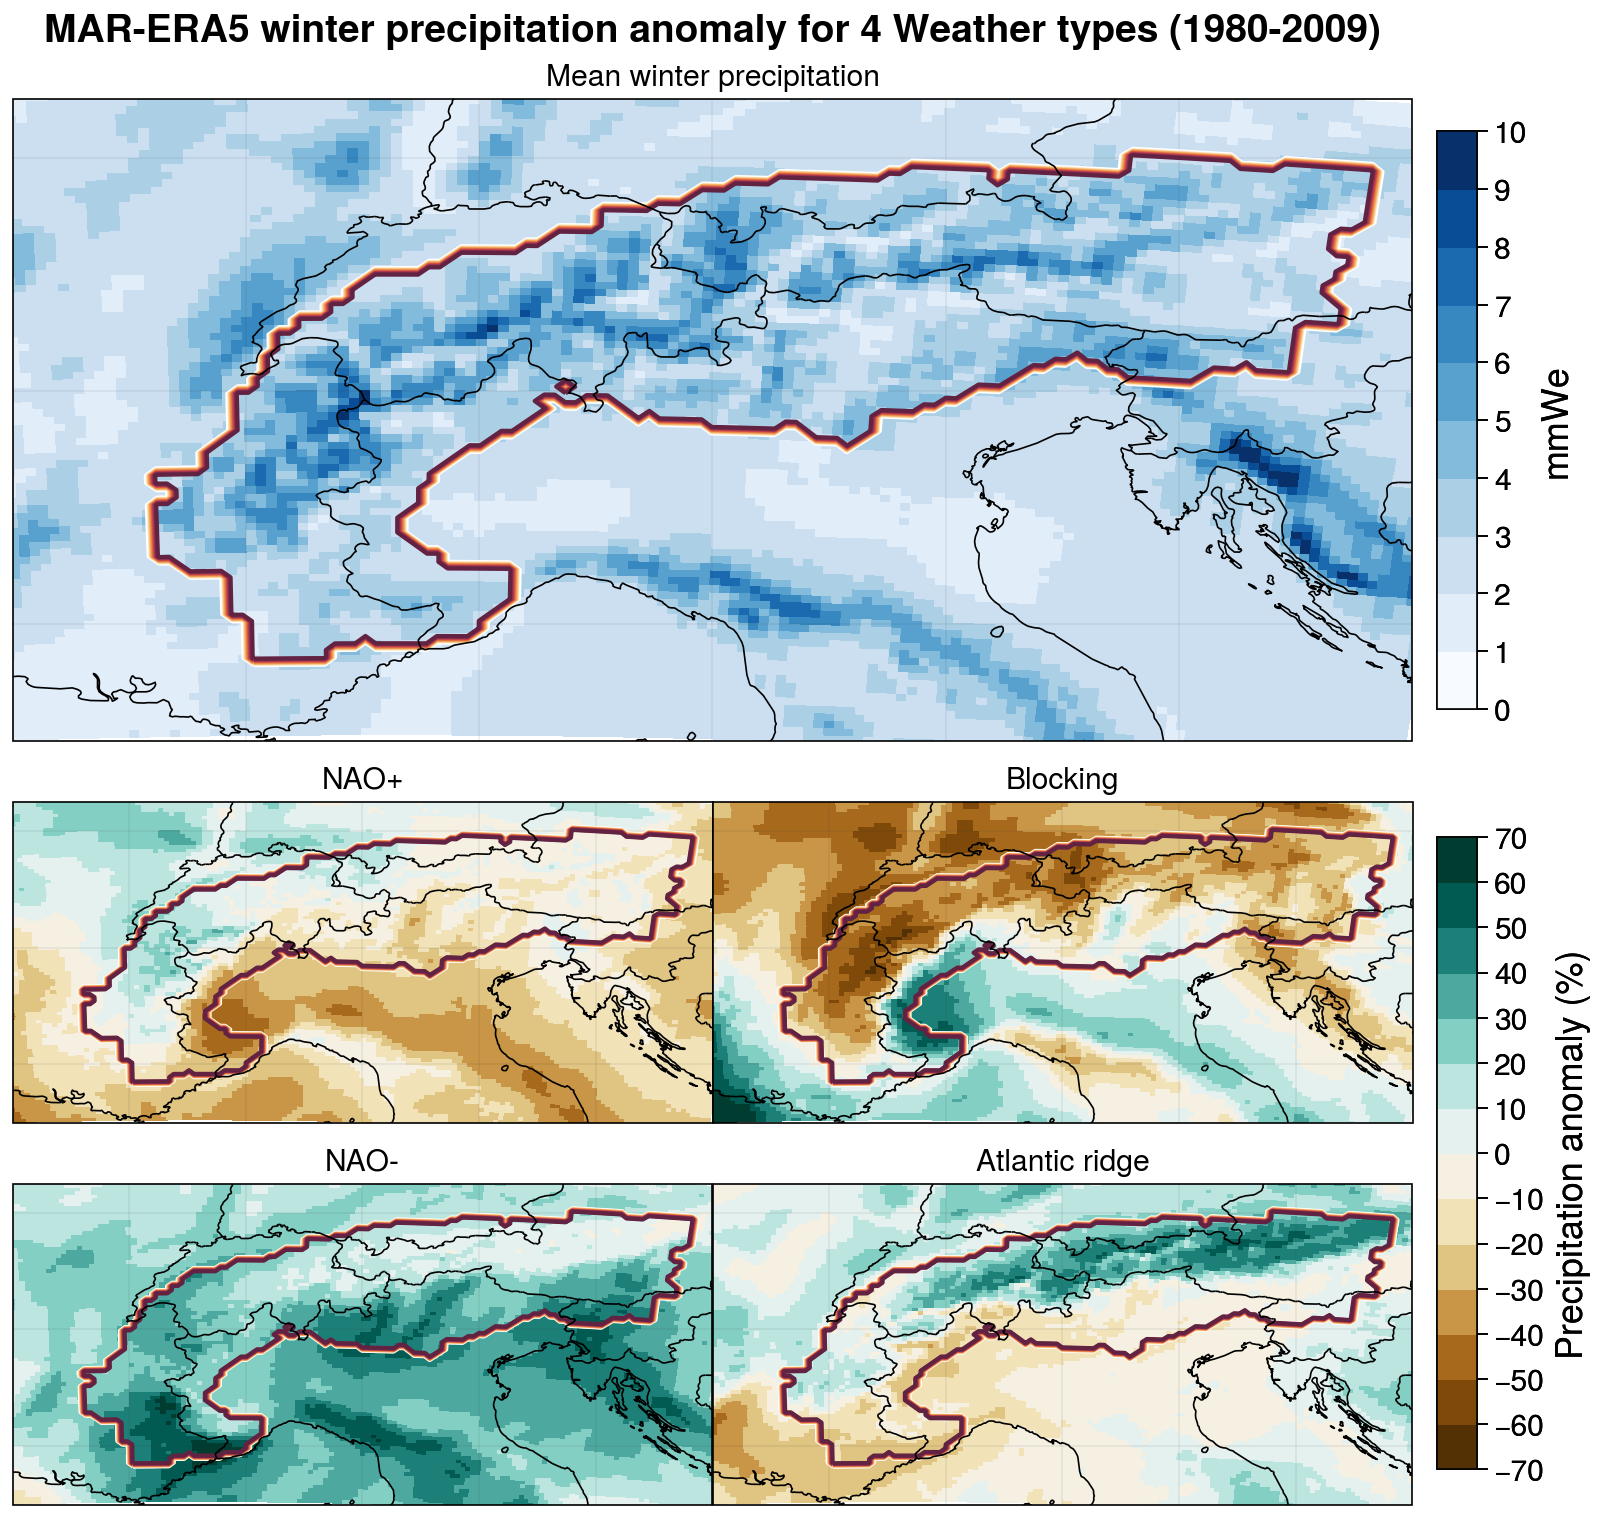

In [10]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MARv3.10_ERA5_precip_weather_types_1980-2009_winter.nc')

plot_five(ds_precip, 'MAR-ERA5 winter precipitation anomaly for 4 Weather types (1980-2009)', 'Mean winter precipitation','Precipitation anomaly (%)',
         dict_WT={'NAO+': 'pr1', 'Blocking': 'pr2', 'NAO-': 'pr3', 'Atlantic ridge': 'pr0'})

/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

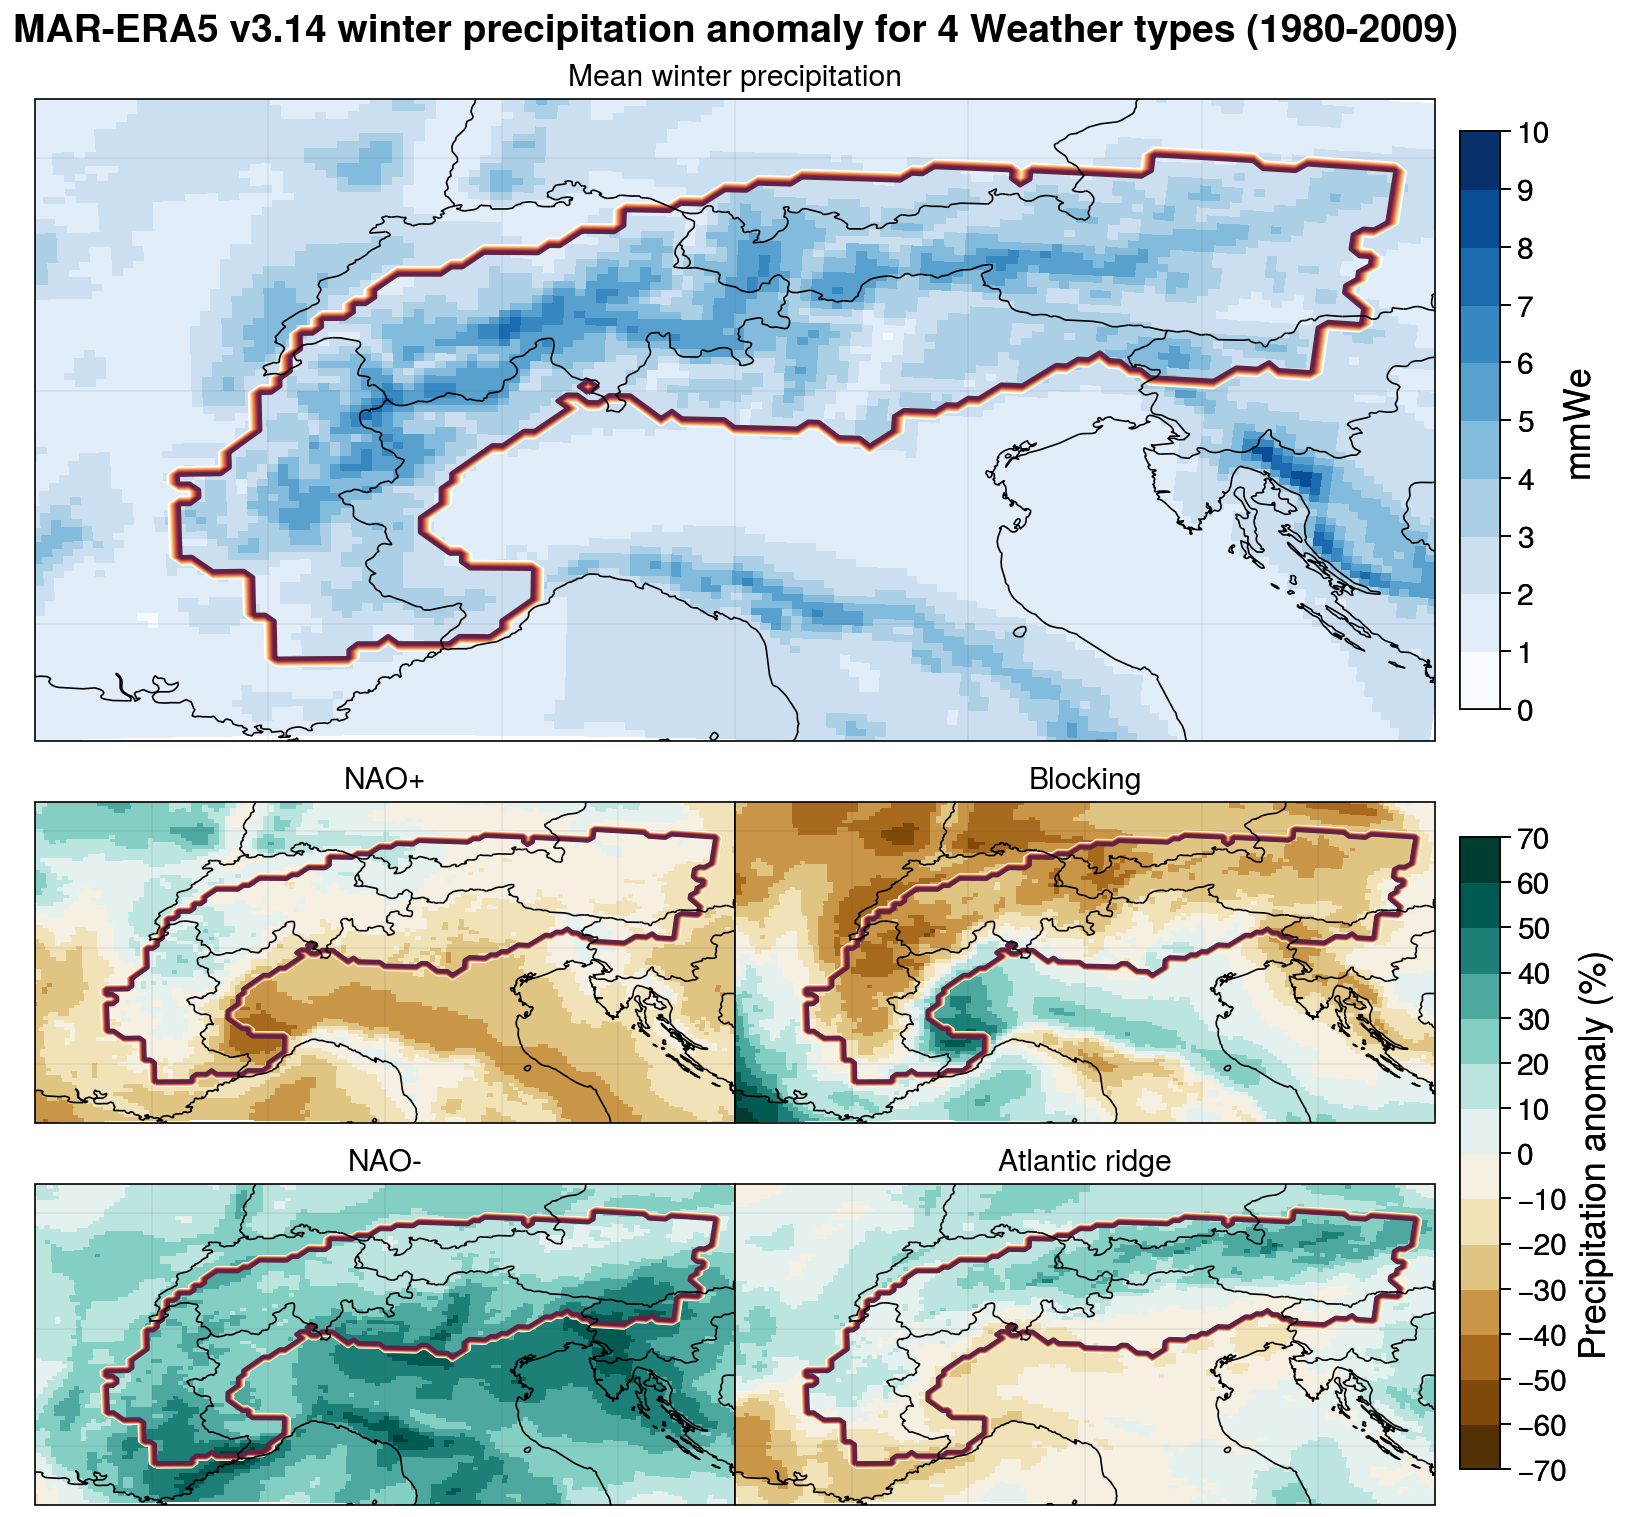

In [11]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1980-2009_winter.nc')

plot_five(ds_precip, 'MAR-ERA5 v3.14 winter precipitation anomaly for 4 Weather types (1980-2009)', 'Mean winter precipitation','Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr1', 'Blocking': 'pr2', 'NAO-': 'pr3', 'Atlantic ridge': 'pr0'})

/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

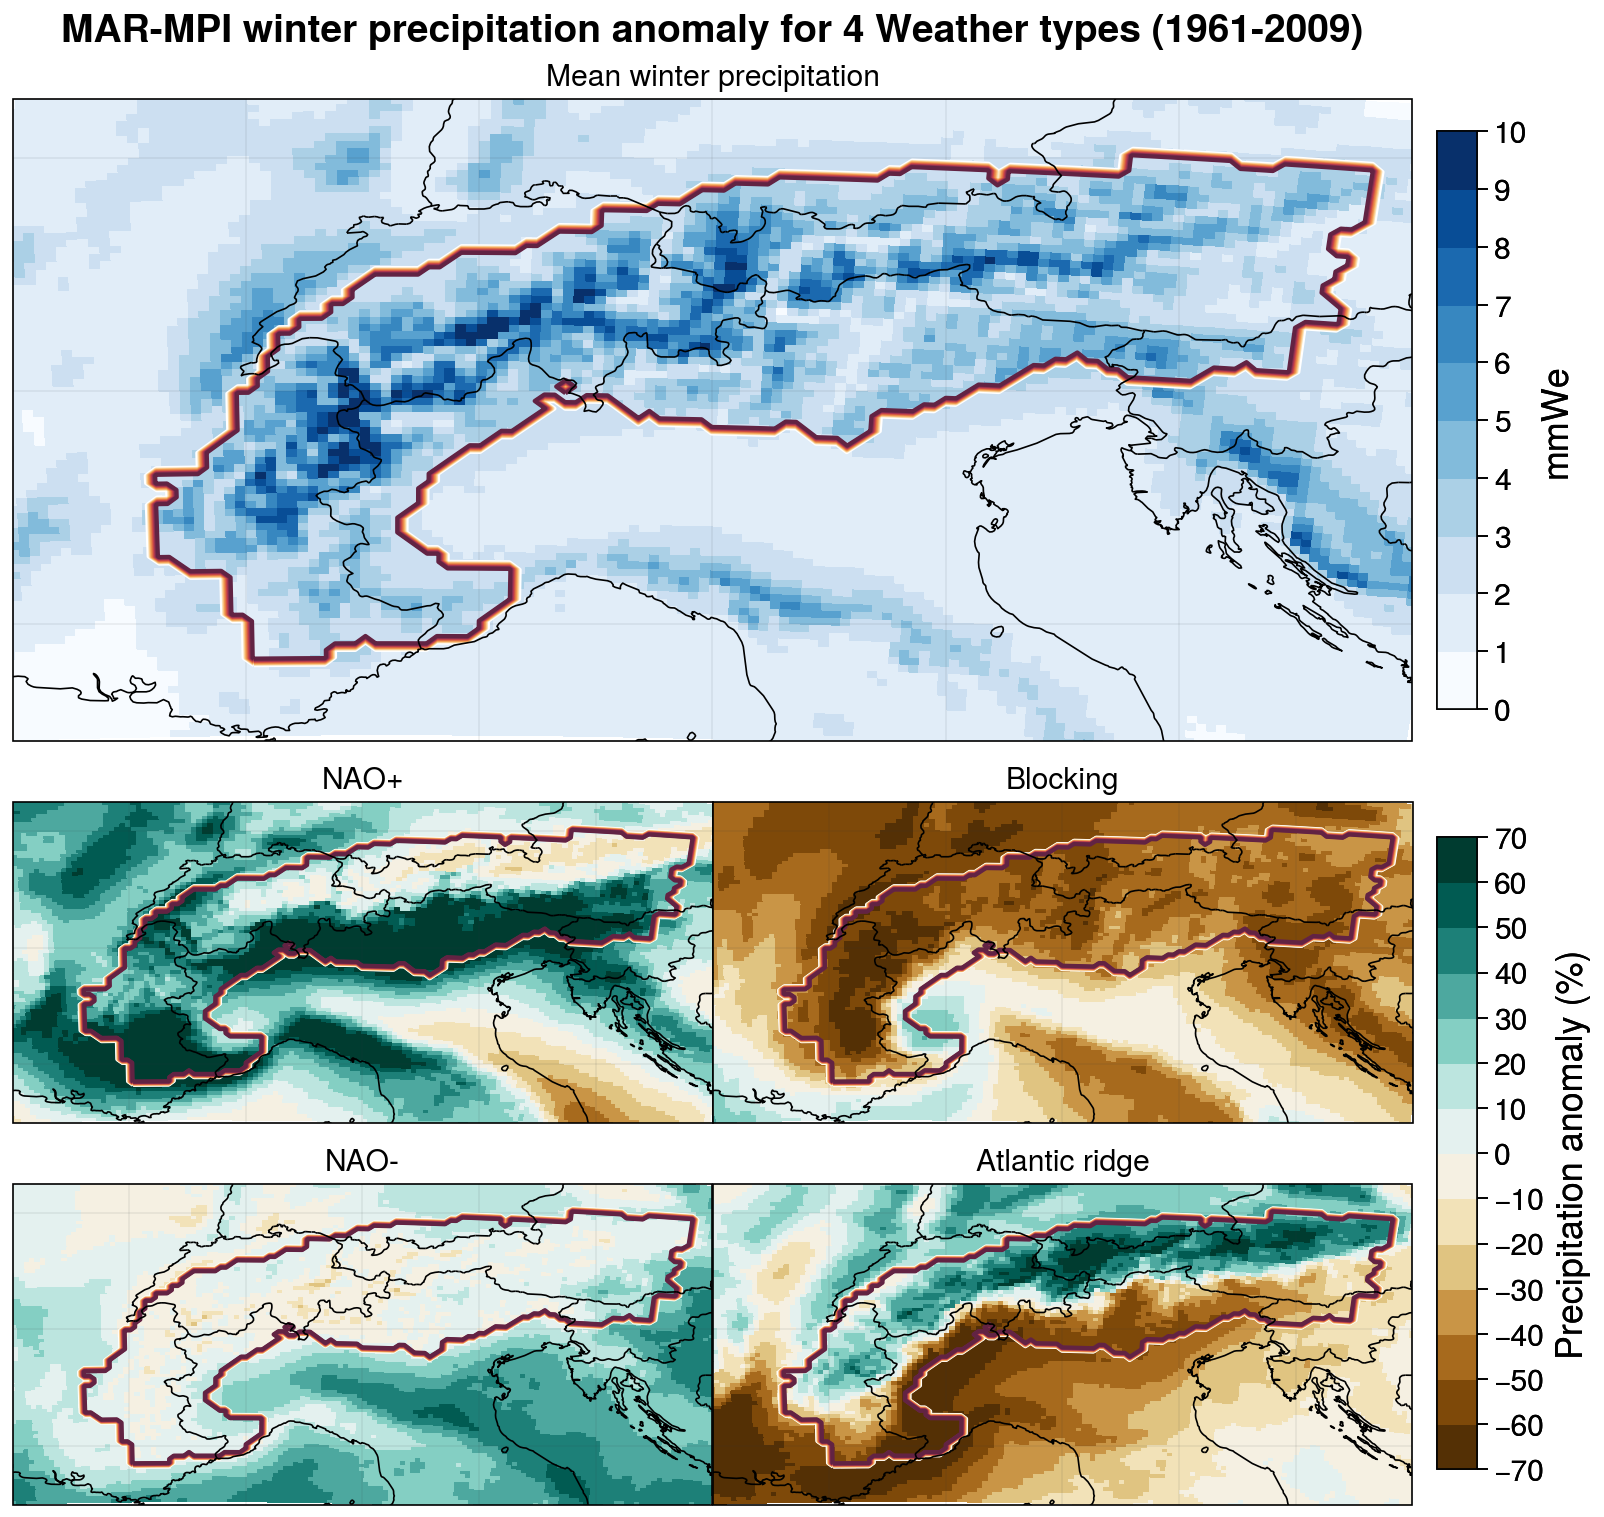

In [12]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1961-2009_winter.nc')

plot_five(ds_precip, 'MAR-MPI winter precipitation anomaly for 4 Weather types (1961-2009)', 'Mean winter precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr1', 'Blocking': 'pr0', 'NAO-': 'pr3', 'Atlantic ridge': 'pr2'})

/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_3819899/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is

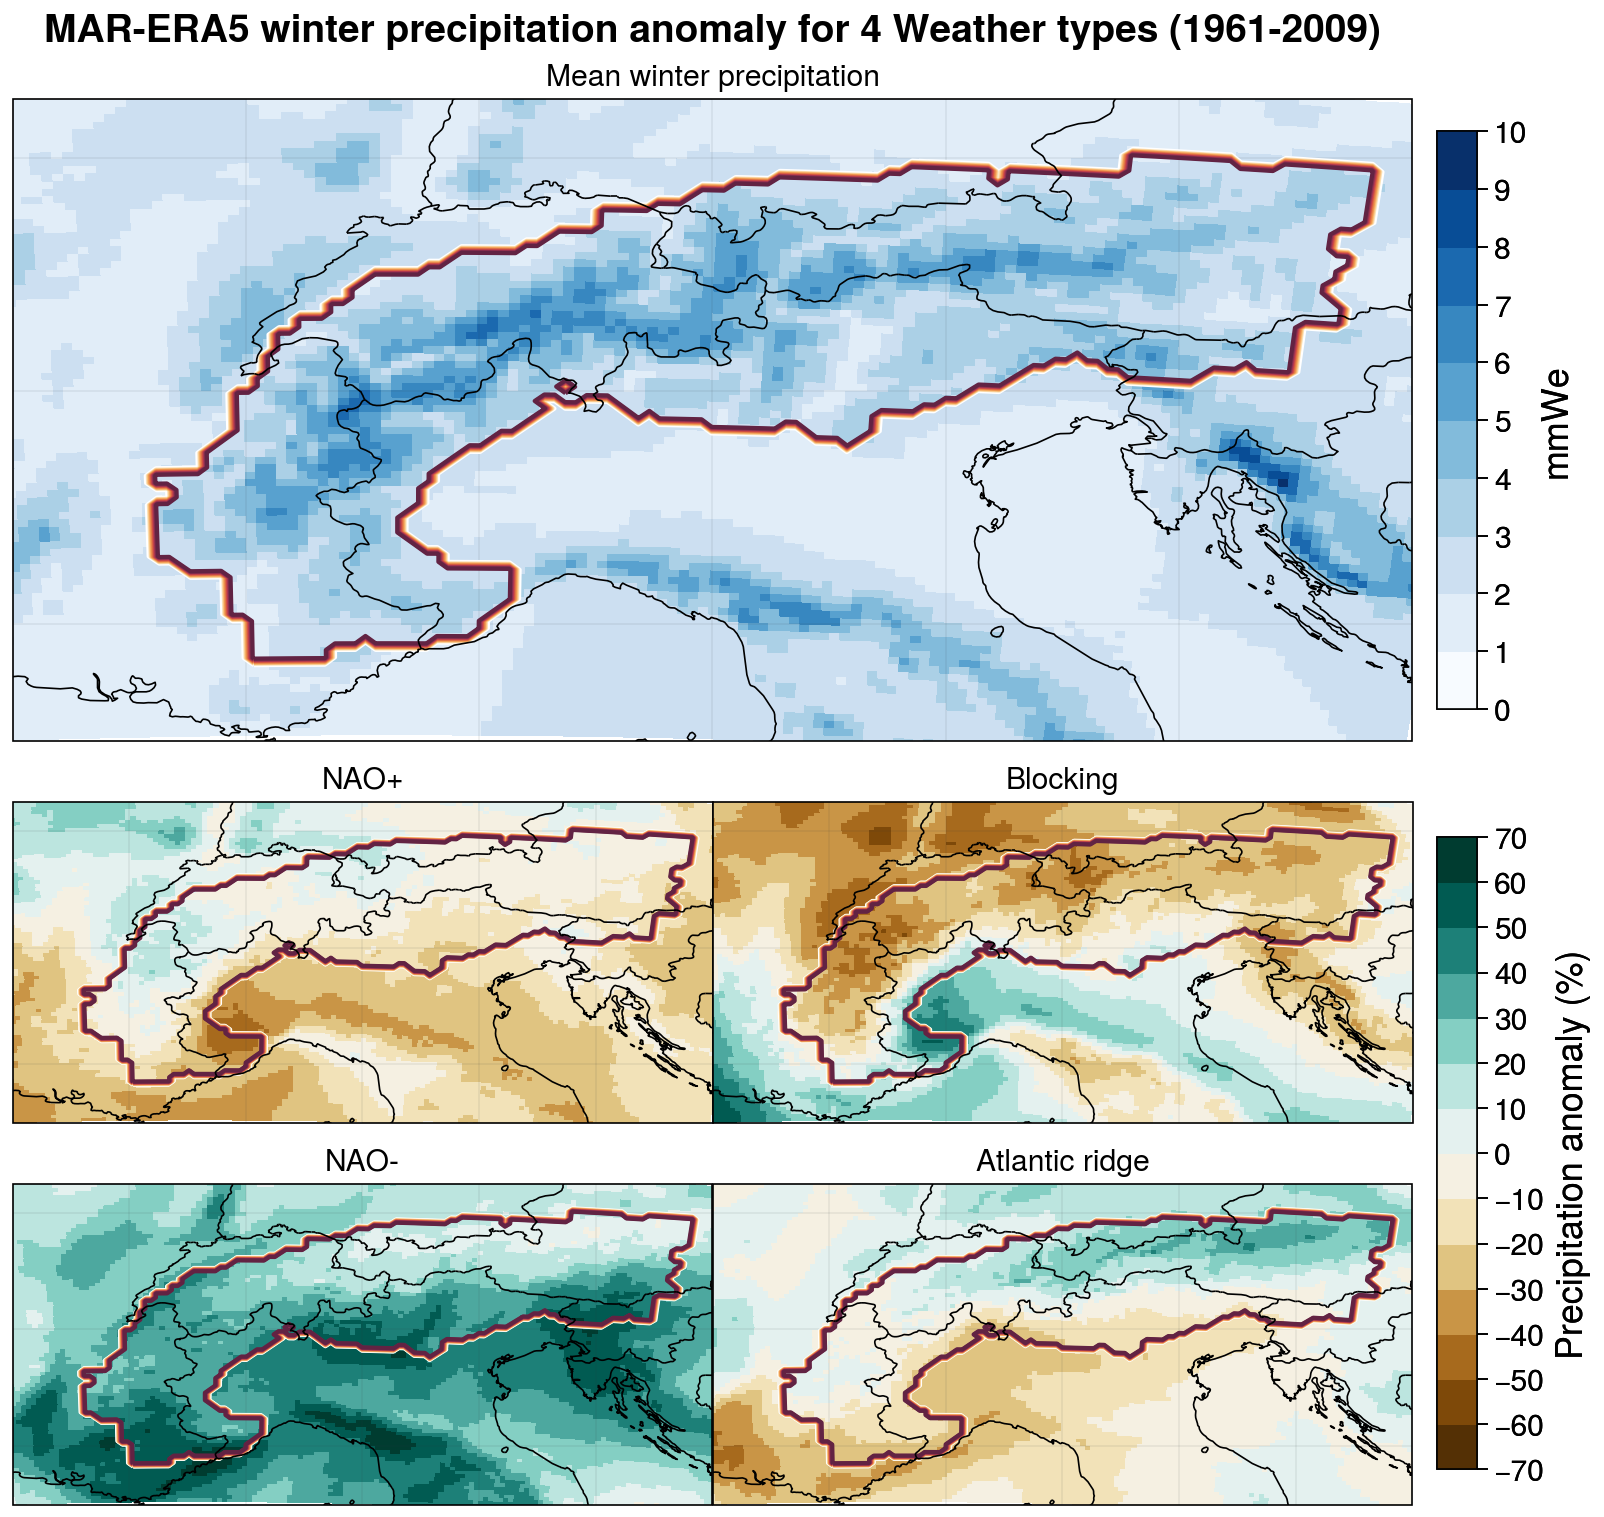

In [13]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1961-2009_winter.nc')

plot_five(ds_precip, 'MAR-ERA5 winter precipitation anomaly for 4 Weather types (1961-2009)', 'Mean winter precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr1', 'Blocking': 'pr3', 'NAO-': 'pr0', 'Atlantic ridge': 'pr2'})

/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is d

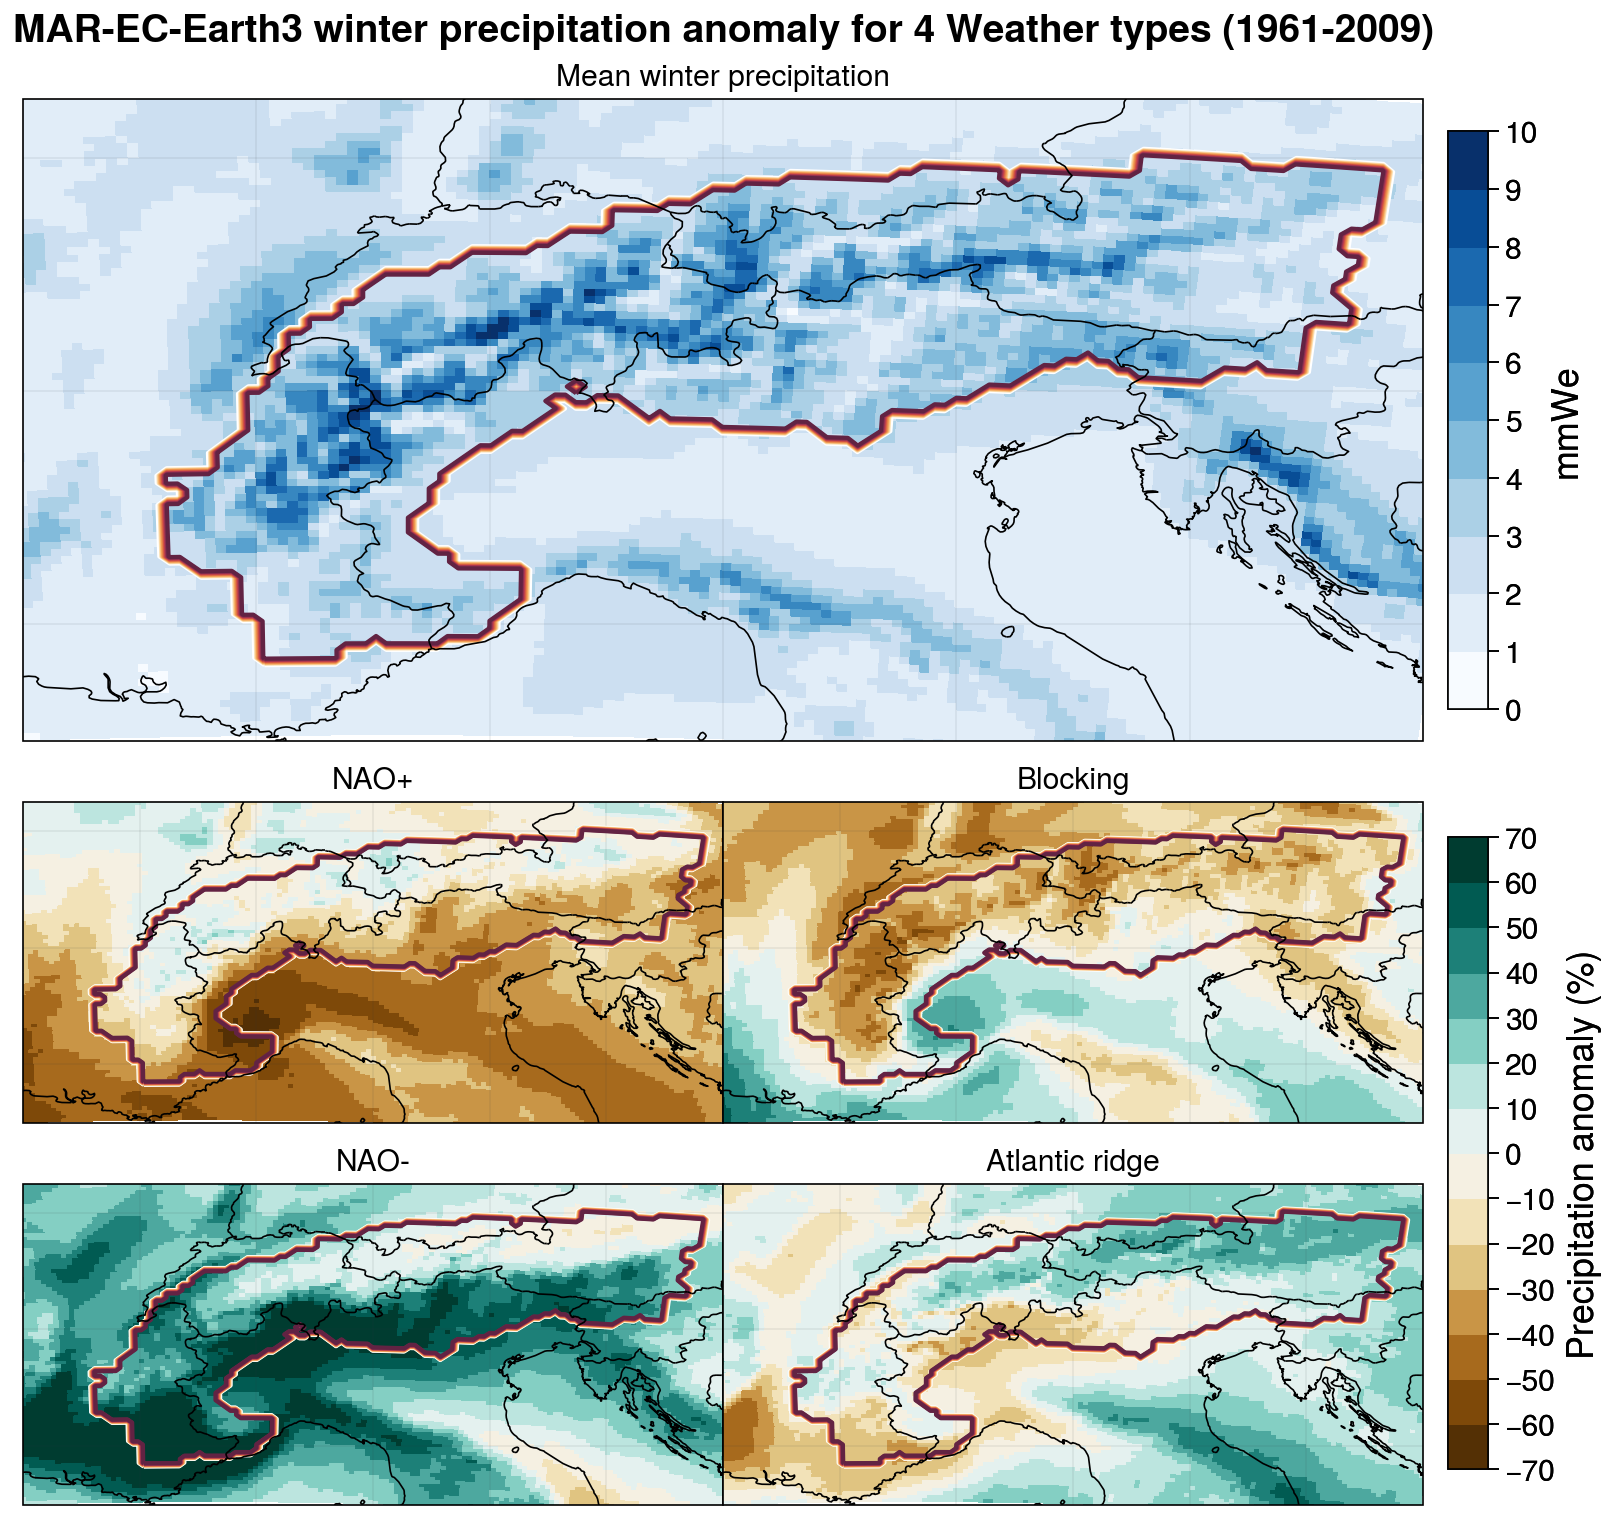

In [9]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_1961-2009_winter.nc')

plot_five(ds_precip, 'MAR-EC-Earth3 winter precipitation anomaly for 4 Weather types (1961-2009)', 'Mean winter precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr3', 'Blocking': 'pr1', 'NAO-': 'pr2', 'Atlantic ridge': 'pr0'})

## SummerJJA

/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is d

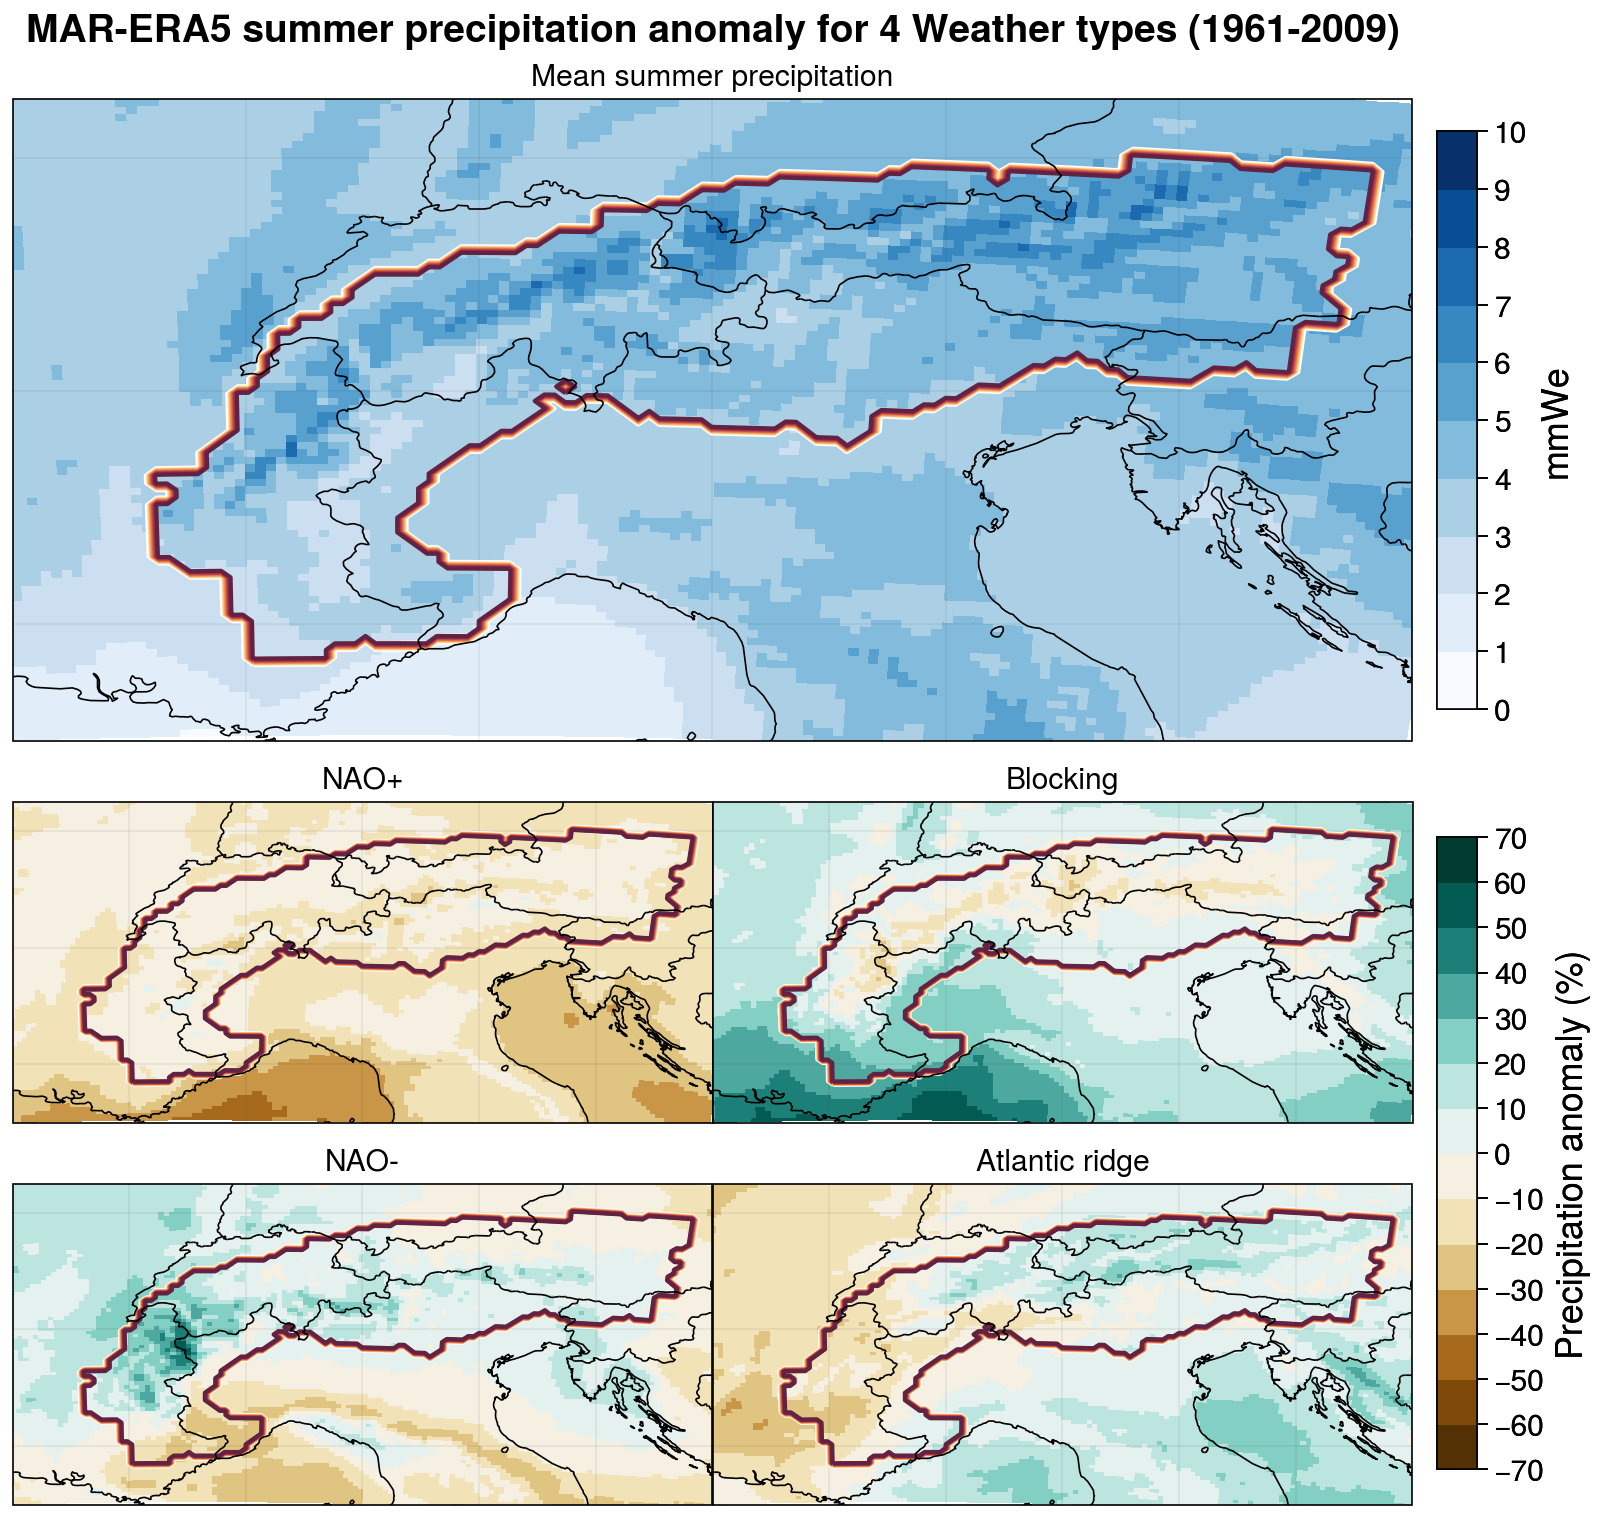

In [13]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1961-2009_summerJJA.nc')

plot_five(ds_precip, 'MAR-ERA5 summer precipitation anomaly for 4 Weather types (1961-2009)', 'Mean summer precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr2', 'Blocking': 'pr0', 'NAO-': 'pr1', 'Atlantic ridge': 'pr3'})

/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is d

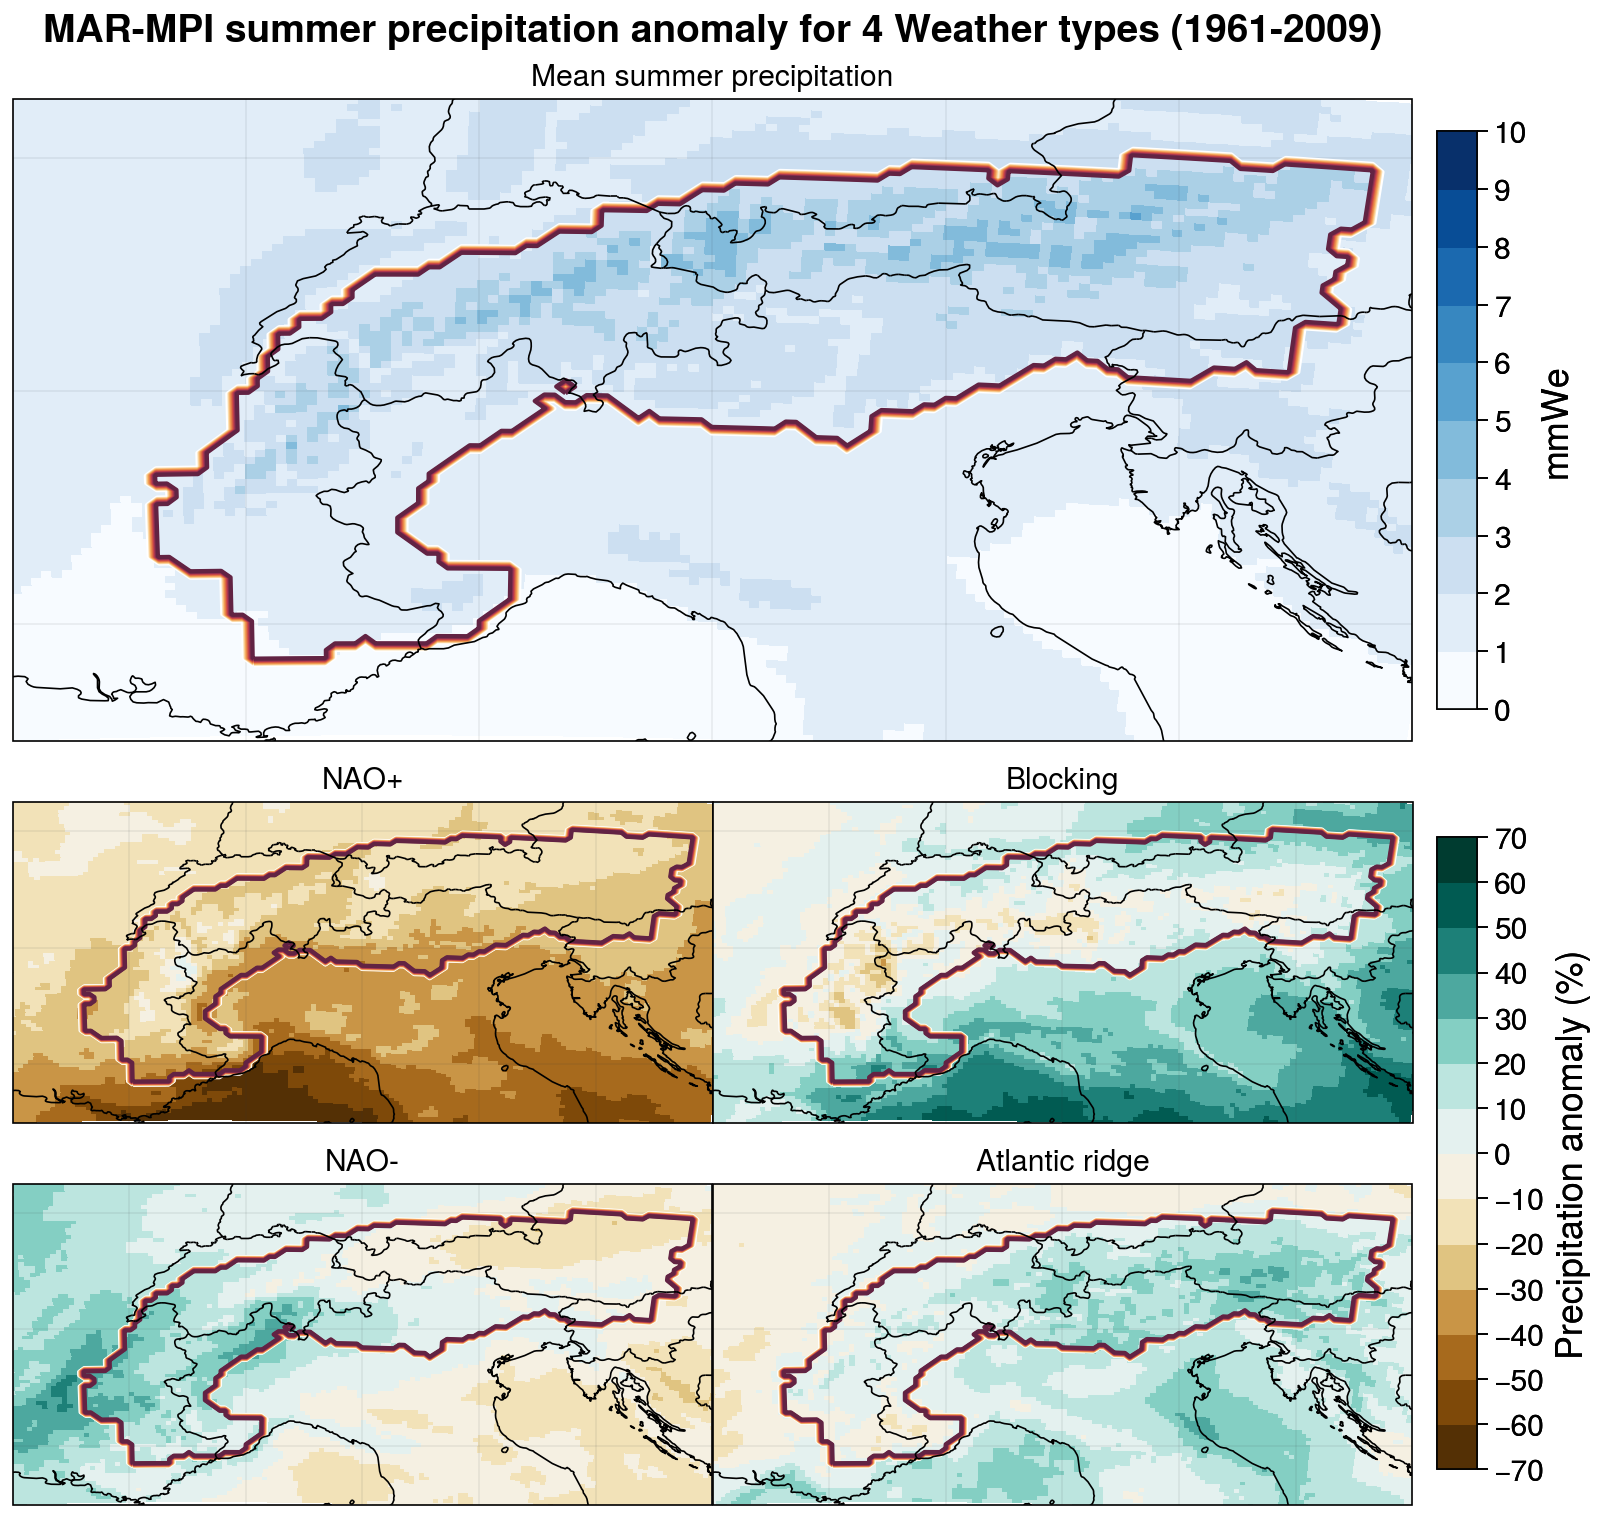

In [14]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1961-2009_summerJJA.nc')

plot_five(ds_precip, 'MAR-MPI summer precipitation anomaly for 4 Weather types (1961-2009)', 'Mean summer precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr2', 'Blocking': 'pr0', 'NAO-': 'pr3', 'Atlantic ridge': 'pr1'})

/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_281419/4123238033.py:2: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is d

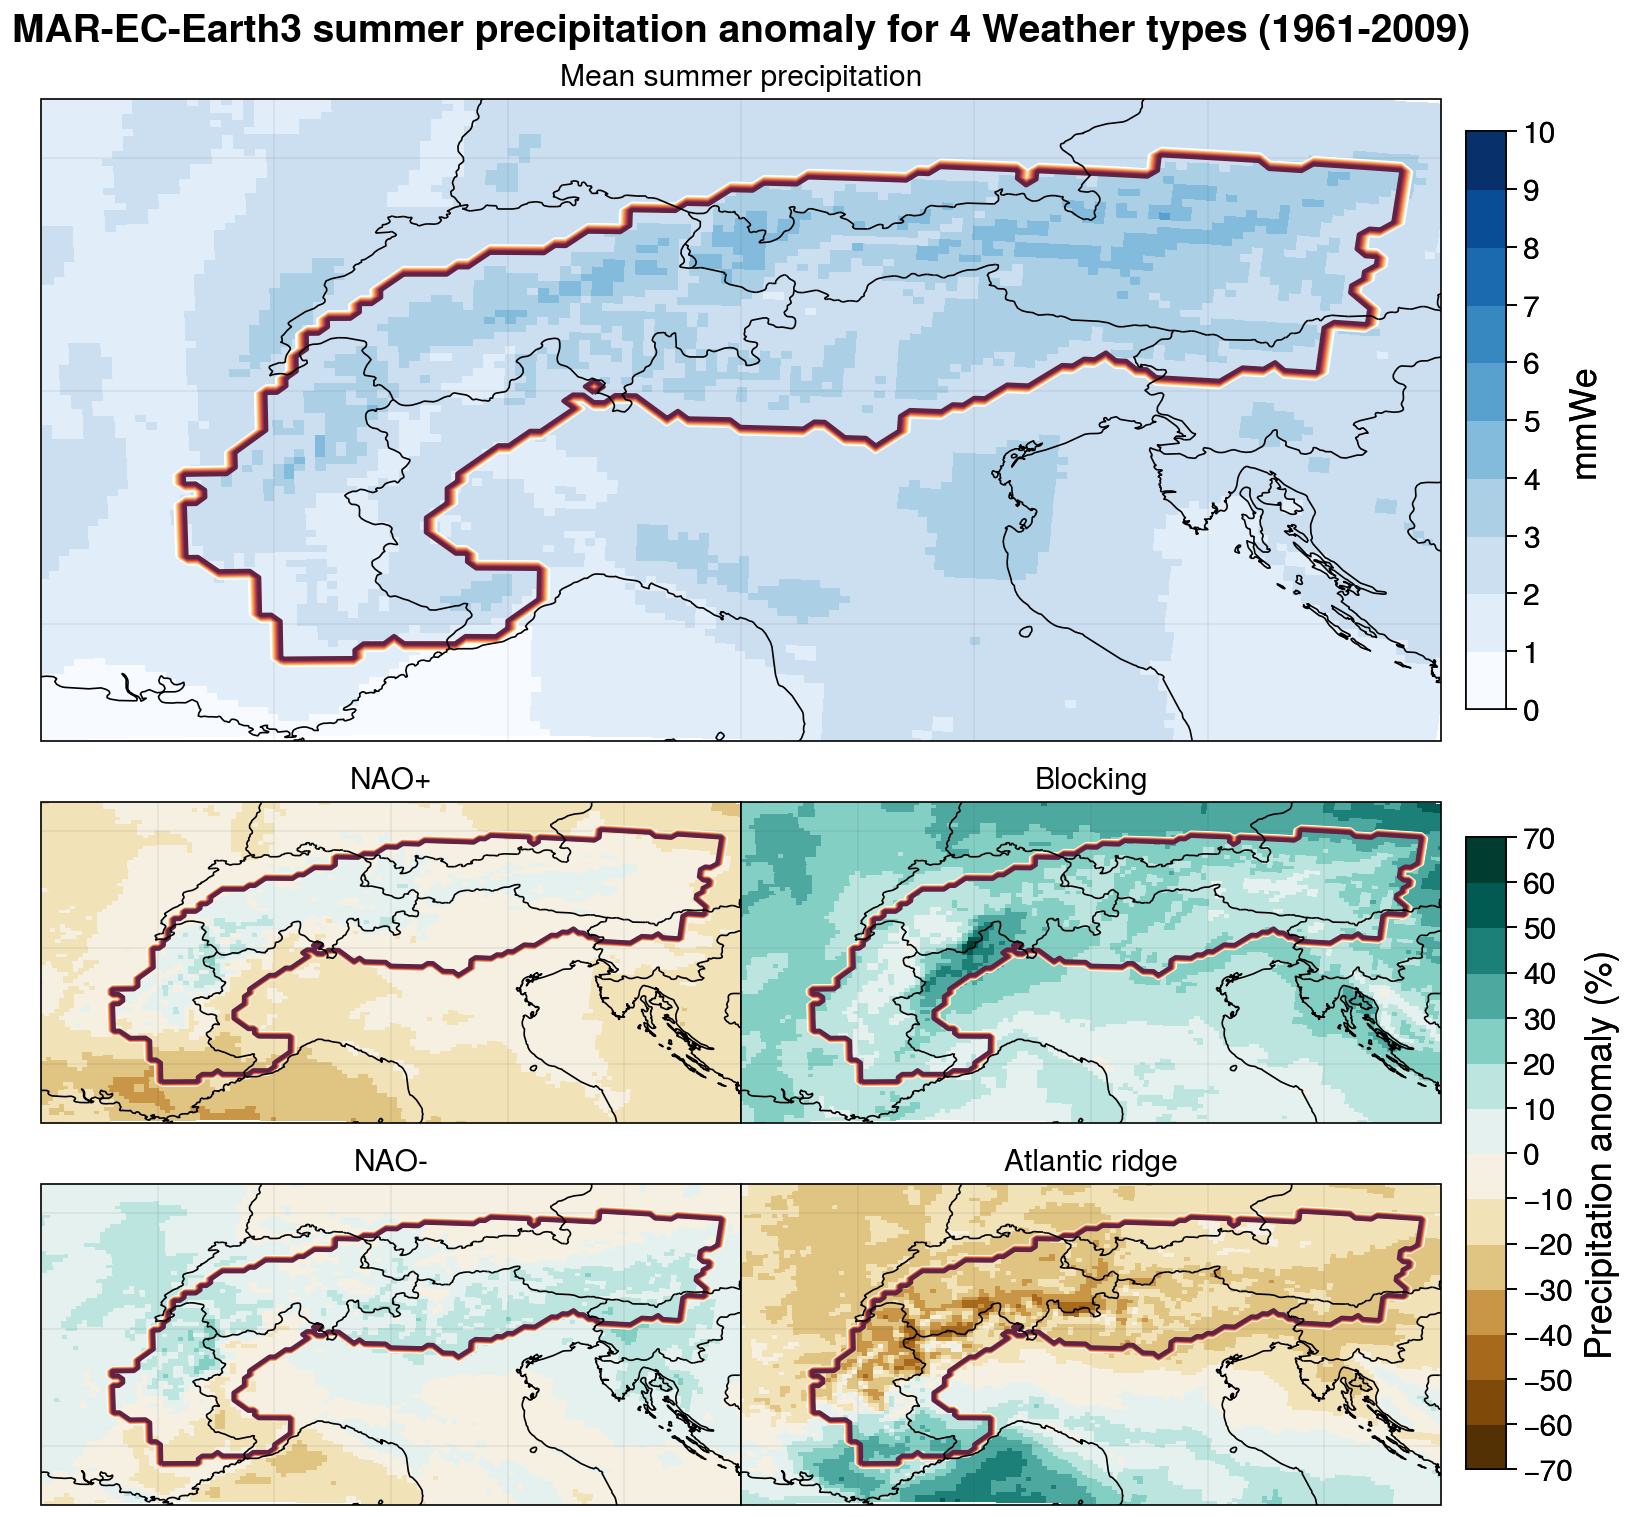

In [10]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_1961-2009_summerJJA.nc')

plot_five(ds_precip, 'MAR-EC-Earth3 summer precipitation anomaly for 4 Weather types (1961-2009)', 'Mean summer precipitation', 'Precipitation anomaly (%)',
          dict_WT={'NAO+': 'pr0', 'Blocking': 'pr2', 'NAO-': 'pr1', 'Atlantic ridge': 'pr3'})